<a href="https://colab.research.google.com/github/isabelabianca/horse-or-human/blob/main/horse_human_classifier_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Checkpoint 2**
## Classificador de imagens utilizando o dataset Horse or Human da biblioteca TensorFlow

▶ Referências: [ Rishi Mishra](https://medium.datadriveninvestor.com/horse-or-human-image-classification-c98b9dc94f6f) e [Mohit Tiwari](https://github.com/Tiwarim386/Horse-vs-Human-Classifier).


In [114]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras

In [115]:
# Importando dataset Horse or Human diretamente do repositório do criador

# Imagens para treinamento
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

# Imagens para validação (teste)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2022-04-30 02:51:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   221MB/s    in 0.6s    

2022-04-30 02:51:29 (221 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2022-04-30 02:51:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [116]:
# Definindo callback que irá antecipar a parada do treinamento caso o modelo atinja a precisão desejada (97% no caso).

class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>.97):
                print("\nParando treinamento por atingir 97% de acurácia")
                self.model.stop_training = True

callbacks = myCallback()

In [127]:
# Descompactando o dataset, que é importado no formato .zip

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [118]:
# Definindo os conjuntos de treinamento e validação para os dois tipos de imagem

# Imagens de cavalo para treinamento
train_horse = os.path.join('/tmp/horse-or-human/horses')

# Imagens de humano para treinamento
train_human = os.path.join('/tmp/horse-or-human/humans')

# Imagens de cavalo para validação
validation_horse = os.path.join('/tmp/validation-horse-or-human/horses')

# Imagens de humano para validação
validation_human = os.path.join('/tmp/validation-horse-or-human/humans')

In [119]:
print('Total de imagens de cavalo para treinamento:', len(os.listdir(train_horse)))
print('Total de imagens de humano para treinamento:', len(os.listdir(train_human)))
print('Total de imagens de cavalo para validação:', len(os.listdir(validation_horse)))
print('Total de imagens de humano para validação:', len(os.listdir(validation_human)))

Total de imagens de cavalo para treinamento: 500
Total de imagens de humano para treinamento: 527
Total de imagens de cavalo para validação: 128
Total de imagens de humano para validação: 128


In [120]:
# Pré-processamento dos dados

# Redimensionando as imagens para 1/255 para normalizar os dados
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Todas as imagens serão redimensionadas para 300x300
# Imagens para treinamento
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  
        target_size=(300, 300),
        batch_size=128,
        class_mode='binary')

# Imagens para validação
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',
        target_size=(300, 300),
        batch_size=32,
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [121]:
# Definindo o modelo

model = keras.Sequential([
    tf.keras.layers.Conv2D(filters = 16, kernel_size=11, strides=4, activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Conv2D(filters = 256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [122]:
# Definindo otimizador e métricas

model.compile(
                loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [123]:
# Treinando o modelo por 15 épocas, ou até que seja executado o callback definido (97% de acurácia)

history=model.fit(
                    train_generator,  
                    validation_data = validation_generator,
                    epochs=15,
                    callbacks=[callbacks]
                  )
                    

Epoch 1/15
9/9 [==============================] - 10s 1s/step - loss: 0.6933 - accuracy: 0.5024 - val_loss: 0.6716 - val_accuracy: 0.5742
Epoch 2/15
9/9 [==============================] - 8s 880ms/step - loss: 0.6380 - accuracy: 0.6602 - val_loss: 0.5979 - val_accuracy: 0.6289
Epoch 3/15
9/9 [==============================] - 8s 889ms/step - loss: 0.4411 - accuracy: 0.7994 - val_loss: 0.3636 - val_accuracy: 0.8750
Epoch 4/15
9/9 [==============================] - 8s 900ms/step - loss: 0.3322 - accuracy: 0.8685 - val_loss: 0.3752 - val_accuracy: 0.8789
Epoch 5/15
9/9 [==============================] - 8s 897ms/step - loss: 0.2491 - accuracy: 0.8968 - val_loss: 0.4327 - val_accuracy: 0.8984
Epoch 6/15
9/9 [==============================] - 8s 897ms/step - loss: 0.2300 - accuracy: 0.9085 - val_loss: 0.7632 - val_accuracy: 0.8438
Epoch 7/15
9/9 [==============================] - 8s 891ms/step - loss: 0.1956 - accuracy: 0.9289 - val_loss: 0.4500 - val_accuracy: 0.8828
Epoch 8/15
9/9 [======

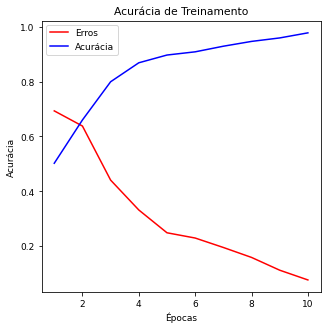

In [124]:
# Avaliando resultados do treinamento

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1 , len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Erros')
plt.plot(epochs , acc , 'b' , label = 'Acurácia' )
plt.title('Acurácia de Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.legend()
plt.rc('font', size = 9)
plt.rc('figure', figsize=[5,5])
plt.show()

In [125]:
local_zip = 'test-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('test-images')
zip_ref.close()

imagens_teste = os.path.join('test-images/test-images')

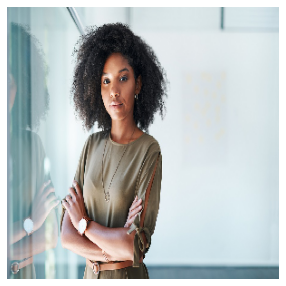

É um humano


In [126]:
# Por fim, nesta célula podemos escolher alguma imagem de humano ou cavalo de nossa pasta de imagens de teste, para que o modelo realize uma predição

path = imagens_teste + "/humano5.jpg"
img = image.load_img(path, target_size=(300, 300))
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis(False)
plt.show()

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
if classes[0]>0.5:
  print("É um humano")
else:
  print("É um cavalo")